# 0. Setup & Imports

In [ ]:
import os
import shutil
import random
import zipfile
import math
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import json
import IPython.display as display
from typing import Tuple, List, Dict

In [ ]:
# Machine learning
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image_dataset_from_directory

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.optimizers import Adam
# from keras.utils import to_categorical
# from keras.layers import Conv2D, MaxPooling2D

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)

TensorFlow version: 2.19.0
GPUs found: []


In [ ]:
# Speedups
AUTOTUNE = tf.data.AUTOTUNE

 This is a special value used with tf.data operations. It allows the TensorFlow runtime to dynamically adjust the number of parallel calls for operations like mapping or prefetching data during model training. This can help improve performance by optimizing how data is loaded and processed.

In [ ]:
# for consistency
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



---



# 1. Paths, unzip dataset

In [ ]:
USE_GOOGLE_DRIVE = True   # Set True if your ZIP is on Drive

DATA_ROOT = Path('/content')  # Colab's working dir
# ZIP_PATH = DATA_ROOT / 'Teeth DataSet.zip'  # adjust name if needed
EXTRACT_DIR = DATA_ROOT / 'teeth_dataset_raw'  # temporary extract location

In [ ]:
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ZIP_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 2: Teeth Classification using Pretrained Models and Streamlit/Teeth DataSet.zip')

### Extract ZIP

In [ ]:
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

assert ZIP_PATH.exists(), f"ZIP file not found at {ZIP_PATH}. Please set ZIP_PATH correctly."

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)
print('Extracted to:', EXTRACT_DIR)

Extracted to: /content/teeth_dataset_raw


### Find the deepest folder that contains class subfolders (heuristic)

In [ ]:
def find_class_root(root: Path) -> Path:
    # if 'root' contains subdirs each with images, that's our class root
    candidates = [p for p in root.rglob('*') if p.is_dir()]
    best = None
    best_score = -1
    for c in candidates:
        subdirs = [d for d in c.iterdir() if d.is_dir()]
        if len(subdirs) < 2:
            continue

        img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif') # score by how many image files are inside subdirs
        count = 0
        for sd in subdirs:
            for f in sd.glob('*'):
                if f.suffix.lower() in img_exts:
                    count += 1
        if count > best_score:
            best_score = count
            best = c
    return best if best is not None else root

In [ ]:
CLASS_ROOT = find_class_root(EXTRACT_DIR)
print('Detected class root:', CLASS_ROOT)

Detected class root: /content/teeth_dataset_raw/Teeth_Dataset/Training


### Inspect classes & counts

In [ ]:
def get_class_counts(class_root: Path) -> Dict[str, int]:
    img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif')
    class_counts = {}
    for cls_dir in sorted([d for d in class_root.iterdir() if d.is_dir()]):
        n = sum(1 for f in cls_dir.rglob('*') if f.suffix.lower() in img_exts)
        if n > 0:
            class_counts[cls_dir.name] = n
    return class_counts

class_counts = get_class_counts(CLASS_ROOT)
print('Classes and counts:', class_counts)

Classes and counts: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}


* (class_root: Path): This is the function's parameter. It specifies that the function expects one argument named class_root, and the type hint : Path suggests that this argument should be a Path object (from the pathlib module).

* -> Dict[str, int]: This is a return type hint. It indicates that this function is expected to return a dictionary where the keys are strings (str) and the values are integers (int). This is likely intended to be a dictionary mapping class names (strings) to the number of images in each class (integers).

In [ ]:
class_counts.keys()

dict_keys(['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'])

In [ ]:
classes_names = list(class_counts.keys())

In [ ]:
print(classes_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [ ]:
print(classes_names[0])

CaS




---



# 2. Create Train/Val/Test Split on Disk

In [ ]:
SPLIT_DIR = Path('/content/teeth_dataset_raw/Teeth_Dataset')

In [ ]:
# Map folders
train_dir = SPLIT_DIR / 'Training'
val_dir   = SPLIT_DIR / 'Validation'
test_dir  = SPLIT_DIR / 'Testing'

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

Train dir: /content/teeth_dataset_raw/Teeth_Dataset/Training
Val dir: /content/teeth_dataset_raw/Teeth_Dataset/Validation
Test dir: /content/teeth_dataset_raw/Teeth_Dataset/Testing


### Testing folder has more than 7 files (classes), we need to remove extra files

In [ ]:
import os

print(os.listdir("/content/teeth_dataset_raw/Teeth_Dataset/Testing"))

['OC', 'outputs', 'OT', 'Gum', 'output', 'output_image.jpg', 'CoS', 'out', 'CaS', 'MC', 'OLP']


In [ ]:
## To remove any files or directories within the Testing folder whose names are not in the classes_names list.
import os
import shutil

test_dir_path = "/content/teeth_dataset_raw/Teeth_Dataset/Testing"

# Iterate through items in the testing directory
for item_name in os.listdir(test_dir_path):
    item_path = os.path.join(test_dir_path, item_name)

    # If the item is not a directory or its name is not in the class names list, remove it
    if not os.path.isdir(item_path) or item_name not in classes_names:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Removed directory: {item_path}")
        else:
            os.remove(item_path)
            print(f"Removed file: {item_path}")

print("Cleanup of Testing directory complete.")

Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/outputs
Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/output
Removed file: /content/teeth_dataset_raw/Teeth_Dataset/Testing/output_image.jpg
Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/out
Cleanup of Testing directory complete.


In [ ]:
# Confirm class counts
def count_images_in_dir(dir_path):
    counts = {}
    img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif')
    for cls_dir in sorted(dir_path.iterdir()):
        if cls_dir.is_dir():
            n = sum(1 for f in cls_dir.rglob('*') if f.suffix.lower() in img_exts)
            counts[cls_dir.name] = n
    return counts

In [ ]:
print("Train counts:", count_images_in_dir(train_dir))
print("Val counts:", count_images_in_dir(val_dir))
print("Test counts:", count_images_in_dir(test_dir))

Train counts: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}
Val counts: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}
Test counts: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}




---



# 4. Visualization: Class Distribution & Samples

In [ ]:
def plot_class_distribution(dir_path: Path, title="Dataset"):
    counts = {}
    for cls_dir in sorted(dir_path.iterdir()):
        if cls_dir.is_dir():
            counts[cls_dir.name] = len(list(cls_dir.glob('*')))
    names = list(counts.keys())
    values = [counts[k] for k in names]
    plt.figure()
    if title == "Training":
        plt.title(f'Class Distribution — Training')
        plt.bar(names, values, color="blue", width=0.9)
    elif title == "Validation":
        plt.title(f'Class Distribution — Validation')
        plt.bar(names, values, color="orange", width=0.9)
    else:
        plt.title(f'Class Distribution — Testing')
        plt.bar(names, values, color="red", width=0.9)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plt.xticks(): This function controls the properties of the x-axis ticks and labels.

* rotation=45: This argument rotates the x-axis tick labels by 45 degrees. This is often useful when you have many labels or long labels that might overlap if displayed horizontally.

* ha='right': This argument sets the horizontal alignment of the rotated tick labels to 'right'. This means the right edge of each label will be aligned with its corresponding tick mark.

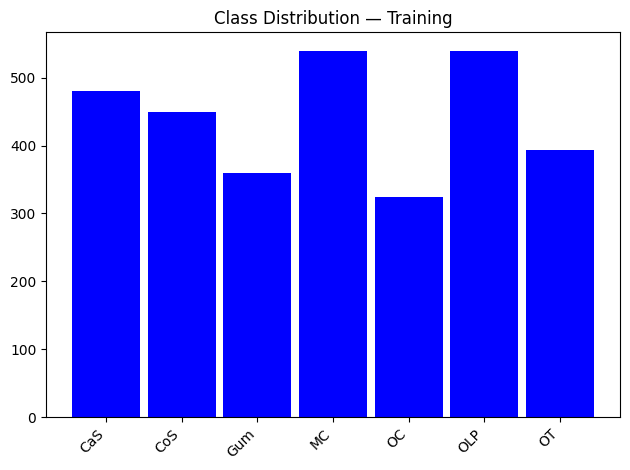

In [ ]:
plot_class_distribution(train_dir, title="Training")

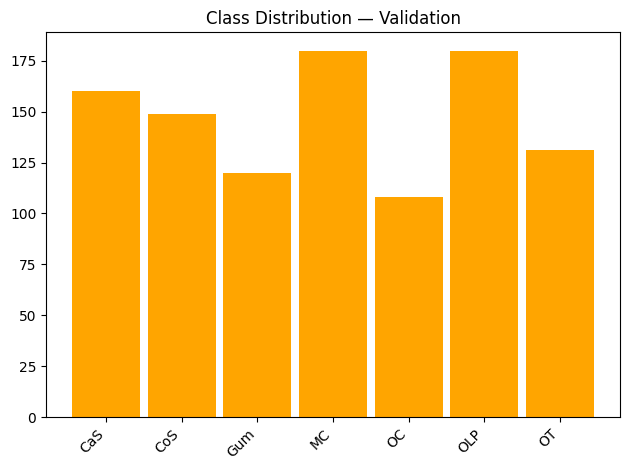

In [ ]:
plot_class_distribution(val_dir, title="Validation")

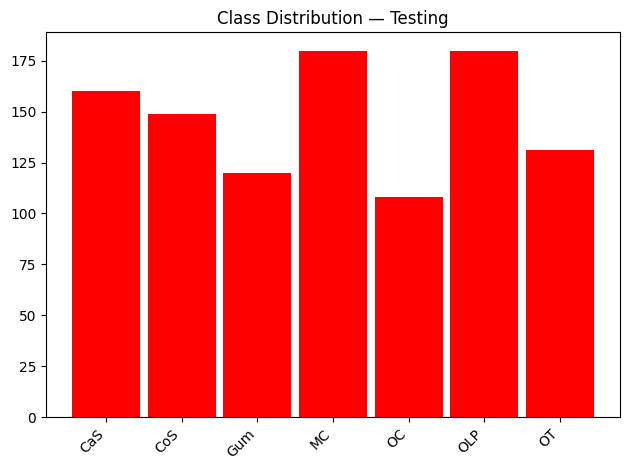

In [ ]:
plot_class_distribution(test_dir, title="Testing")

In [ ]:
def show_sample_images(dir_path: Path, title="Dataset", img_per_class=4, img_size=(128, 128)):
    import itertools
    img_paths = []
    classes = sorted([d.name for d in dir_path.iterdir() if d.is_dir()])
    for cls in classes:
        cls_dir = dir_path / cls
        samples = list(cls_dir.glob('*'))[:img_per_class]
        img_paths.extend(samples)
    cols = img_per_class
    rows = len(classes)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, p in enumerate(img_paths, 1):
        img = keras.utils.load_img(p, target_size=img_size)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(p.parent.name, fontsize=8)
        plt.axis('off')
    plt.suptitle(f'Sample Images — {title}', y=1.02)
    plt.tight_layout()
    plt.show()

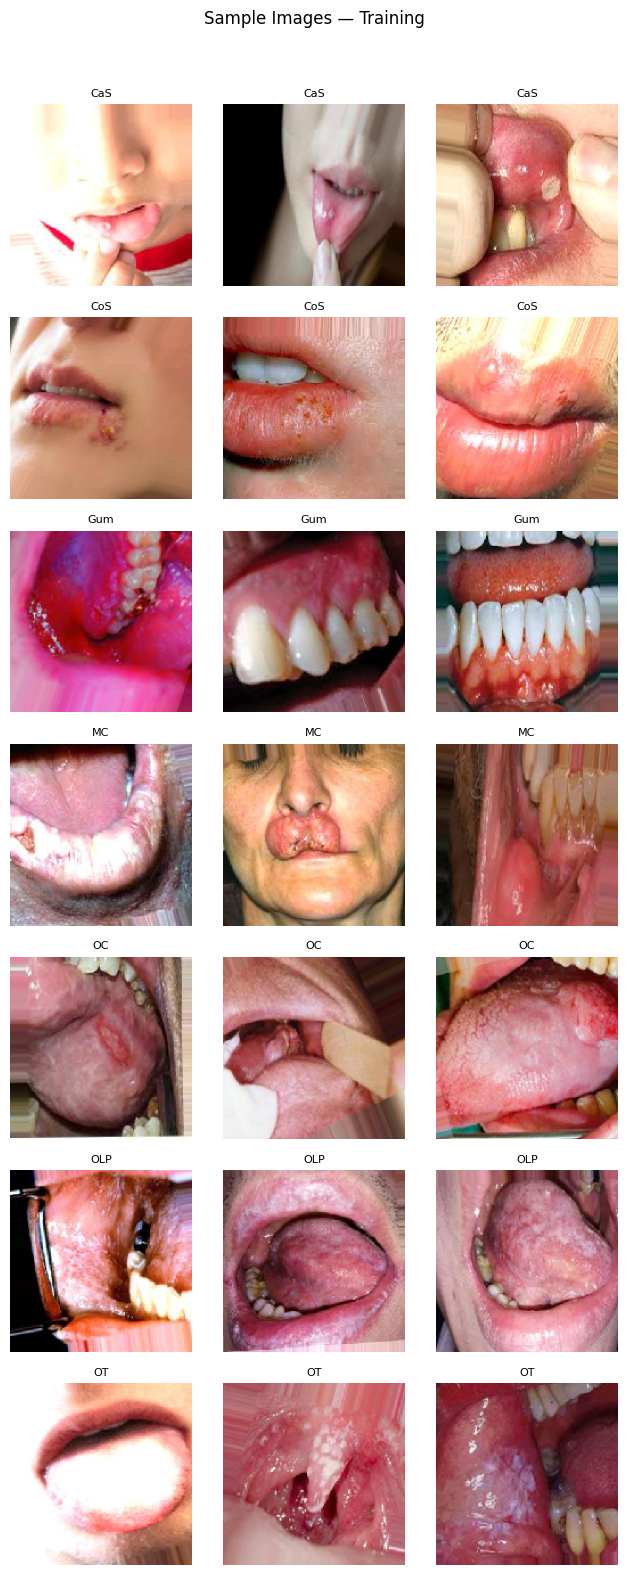

In [ ]:
show_sample_images(train_dir,  title="Training", img_per_class=3, img_size=(160, 160))

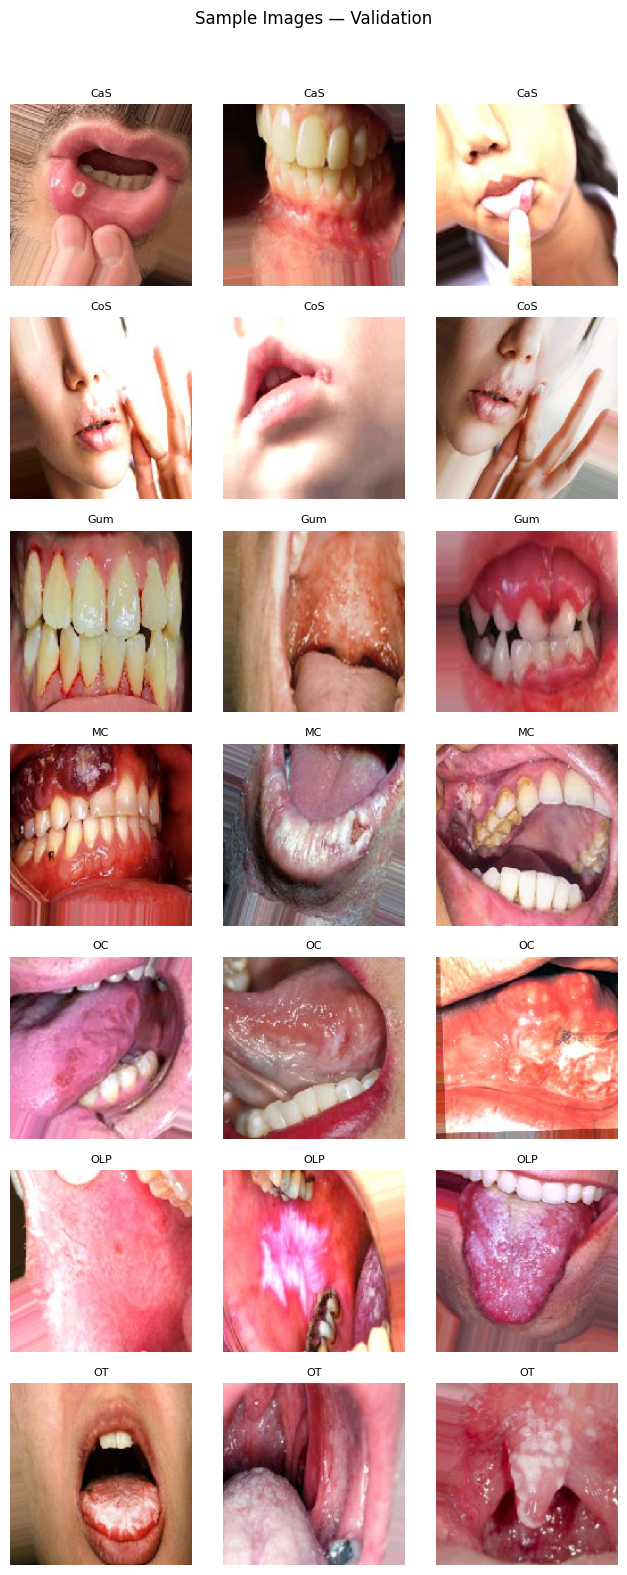

In [ ]:
show_sample_images(val_dir, title="Validation", img_per_class=3, img_size=(160, 160))

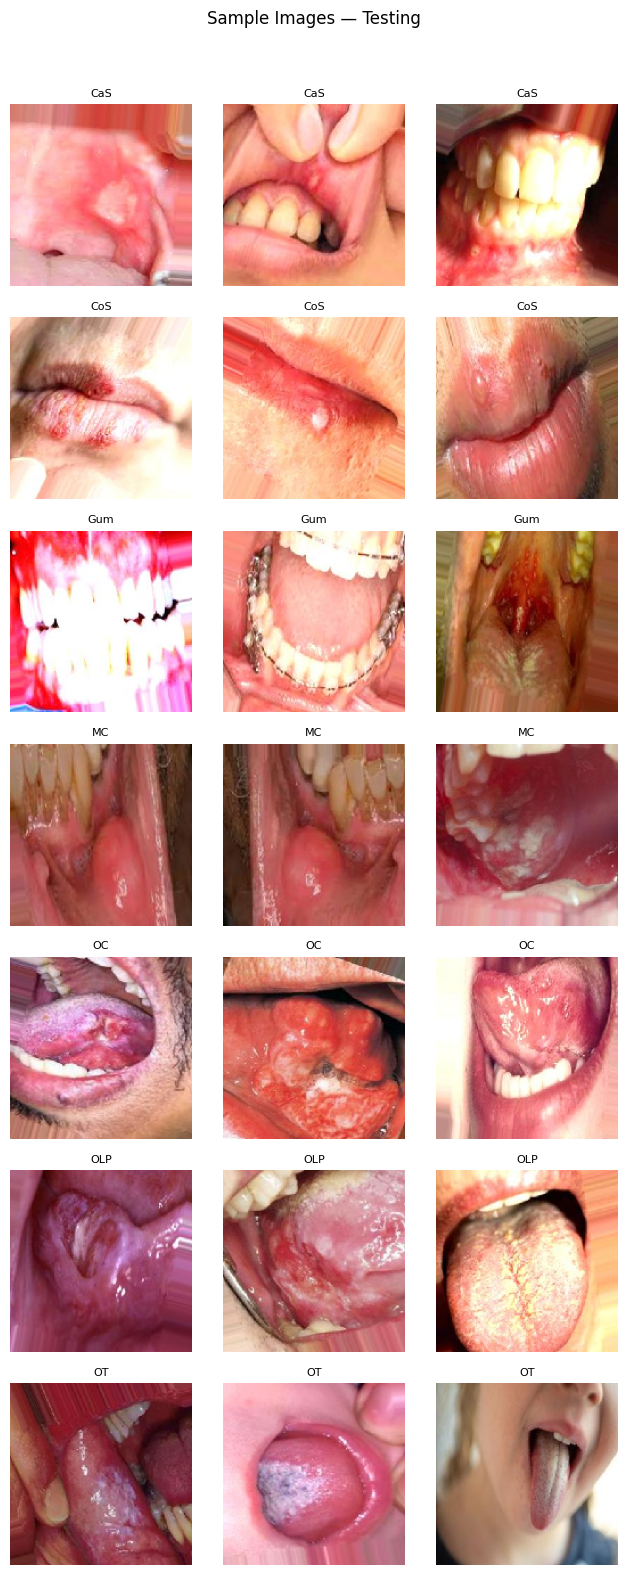

In [ ]:
show_sample_images(test_dir, title="Testing", img_per_class=3, img_size=(160, 160))



---



# 5. Augmentation & Normalization

In [ ]:
IMG_SIZE = (224, 224)
# IMG_SIZE = (128, 128)
# IMG_SIZE = (64, 64)
BATCH_SIZE = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    # label_mode='categorical',   ## One Hot Encoding
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3087 files belonging to 7 classes.


This code snippet creates a tf.data.Dataset for your training data using tf.keras.preprocessing.image_dataset_from_directory.

* SPLIT_DIR / 'train': Specifies the directory containing your training images.

* labels='inferred': Tells the function to infer the class labels from the directory structure (each subdirectory within the SPLIT_DIR / 'train' is treated as a class).

* label_mode='int': Specifies that the labels should be returned as integers (0, 1, 2, ...).

* image_size=IMG_SIZE: Resizes all images to the dimensions specified by IMG_SIZE.

* batch_size=BATCH_SIZE: Groups the images into batches of size BATCH_SIZE.

* shuffle=True: Shuffles the data, which is important for training.

* seed=SEED: Sets a random seed for shuffling to ensure reproducibility.

This creates a train_ds object that you can use to feed data into your model during training.

you can select label_mode ="int" and use loss function -> "sparse_categorical_crossentropy"

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1028 files belonging to 7 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1028 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print('Classes:', class_names)

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [ ]:
# Prefetch & cache
def configure(ds, training=False):
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)  # shuffles the dataset with a buffer size of 1000. Shuffling is important during training to prevent the model from learning the order of the data.
    return ds.prefetch(AUTOTUNE)

In [ ]:
# didn't use the function above, but did the same thing.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

applies the prefetch transformation to the dataset.

prefetch overlaps the data preprocessing and model execution, allowing the next batch of data to be loaded while the current batch is being processed by the model.

AUTOTUNE allows TensorFlow to automatically determine the optimal number of elements to prefetch.

In [ ]:
from keras.models import Sequential
from keras import layers

# Data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
    layers.RandomTranslation(0.02, 0.02)
    # layers.RandomHeight(0.02),
    # layers.RandomWidth(0.02),
    # layers.Rescaling(1./255),
    # layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])
], name='augmentation')

The selected code creates a Keras Sequential model named augmentation that applies data augmentation techniques to images. Data augmentation is used during training to artificially increase the size and diversity of the training dataset, which helps to improve the model's ability to generalize to unseen data and prevent overfitting.

* layers.RandomFlip("horizontal"): This layer randomly flips images horizontally.

* layers.RandomRotation(0.08): This layer randomly rotates images by a factor of 0.08. The rotation angle is within the range [-0.08 * 2PI, 0.08 * 2PI].

* layers.RandomZoom(0.08): This layer randomly zooms in or out on images by a factor of 0.08.

* layers.RandomContrast(0.08): This layer randomly adjusts the contrast of images by a factor of 0.08.

In [ ]:
# Normalization to [0, 1]
# def normalize_img(img):
#     normalized_img = tf.cast(img, tf.float32) / 255.0

#     return normalized_img

In [ ]:
# # Normalization to [-1, 1], sometimes better with gradient flow during training
# def normalize_img(img): # preprocess(x)
#     normalized_img = tf.cast(img, tf.float32) / 127.5 - 1.0

#     return normalized_img

def normalize_img(img): # preprocess(x): This line defines the function normalize_img which is intended to take an image tensor img as input.

img = tf.cast(img, tf.float32) / 127.5 - 1.0: This line performs the normalization calculation. It casts the input tensor img to the float32 data type, divides the pixel values by 127.5, and then subtracts 1.0. This scales the original pixel values (typically in the range of 0-255) to the range of [-1, 1].

This range is often used when working with certain types of neural networks, such as those that utilize tanh activation functions or when using pre-trained models that were trained on data normalized to this range.

In [ ]:
# def preprocess_with(ds, training=False):
#     return (ds
#             .map(lambda x, y: (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE) if training else ds
#            ).map(lambda x, y: (normalize_img(x), y), num_parallel_calls=AUTOTUNE)

## Didn't add Augmentation because it is added in the preprocessing functions in the pretrained models.

In [ ]:
# def preprocess_with(ds, training=False):
#     if training:
#         return ds.map(lambda x, y: (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE)
#     else:
#         return ds

* If training is True, it applies the data_augmentation layer to the images in the dataset using .map().
The num_parallel_calls=AUTOTUNE argument allows for parallel processing of the mapping operation for better performance.

* Regardless of the training flag, it then applies the preprocess function (which you defined earlier to normalize the images) to the images in the dataset using another .map() call, also with num_parallel_calls=AUTOTUNE.

In [ ]:
## configure() for all datasets, augmentation for train_ds
# train_ds_pp = configure(preprocess_with(train_ds, training=True), training=True)
# val_ds_pp = configure(preprocess_with(val_ds, training=False), training=False) # training=False -> no augmentation in training.
# test_ds_pp = configure(preprocess_with(test_ds, training=False), training=False)

The selected code applies the configure and preprocess_with functions to your training, validation, and test datasets.

For the train_ds, it calls preprocess_with with training=True to apply both augmentation and normalization, and then calls configure with training=True to apply shuffling and prefetching.

For the val_ds and test_ds, it calls preprocess_with with training=False to apply only normalization, and then calls configure with training=False to apply only prefetching.

This sets up the data pipelines for each dataset, ensuring that data is augmented and normalized for training, and only normalized and prefetched for evaluation and testing.

In [ ]:
# # Show augmented samples
# def preview_exact_augment(ds, n=5):
#     # Take one batch from the ORIGINAL dataset (not augmented)
#     batch = next(iter(ds))
#     imgs, labels = batch

#     # Restrict to n images
#     imgs = imgs[:n]
#     labels = labels[:n]

#     # Originals (from image_dataset_from_directory are already 0–255 uint8)
#     originals = imgs.numpy().astype("uint8")

#     # Apply augmentation manually (we pass imgs through augmentation only)
#     aug_imgs = data_augmentation(imgs, training=True).numpy()
#     aug_imgs = np.clip(aug_imgs, 0, 255).astype("uint8")

#     # Plot originals vs augmented
#     plt.figure(figsize=(10, 2*n))
#     for i in range(n):
#         # Original
#         plt.subplot(n, 2, 2*i+1)
#         plt.imshow(originals[i])
#         plt.title(f'Original: {class_names[labels[i].numpy()]}')
#         plt.axis('off')

#         # Augmented
#         plt.subplot(n, 2, 2*i+2)
#         plt.imshow(aug_imgs[i])
#         plt.title(f'Augmented: {class_names[labels[i].numpy()]}')
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()


In [ ]:
# preview_exact_augment(train_ds, n=6)



---



# 6. Hyperparameters & Utility Functions

### Hyper parameters

### **If you let all layers trainable, it will get 99% accuracy immediately (not in this model) in (resnet18)**

In [ ]:
IMG_SIZE = (224, 224)
# IMG_SIZE = (128, 128)
BATCH_SIZE = 32
INITIAL_EPOCHS = 20       # for head training (you already did this)
FINETUNE_EPOCHS = 20       # 12     # short, we will monitor
LEARNING_RATE = 1e-3
FINE_TUNE_LR = 1e-4
MIN_LR = 1e-7             # do not let ReduceLROnPlateau go crazy low
PATIENCE = 6   # 4
UNFREEZE_LAST_N = 20      # unfreeze only last 20 top-level layers to start
# UNFREEZE_LAST_N = None    # unfreeze all layers

* `IMG_SIZE = (64, 64)` this made the model underfit.

* `UNFREEZE_LAST_N = 20` Epoch 12: val_accuracy improved from 0.94163 to 0.95817, saving model to /content/MobileNetV2_best/best model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 445ms/step - accuracy: 0.9846 - loss: 0.0483 - val_accuracy: 0.9582 - val_loss: 0.1239 - learning_rate: 2.0000e-05

* `UNFREEZE_LAST_N = None` unfreezes all layers.
    Epoch 12: val_accuracy did not improve from 0.89981
    97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 482ms/step - accuracy: 0.9954 - loss: 0.0216 - val_accuracy: 0.8842 - val_loss: 0.4506 - learning_rate: 1.0000e-04
    Restoring model weights from the end of the best epoch: 10.



In [ ]:
def compute_class_weights(train_dir: Path, class_names: List[str]) -> Dict[int, float]:
    counts = {i: len(list((train_dir / cls).glob('*'))) for i, cls in enumerate(class_names)}
    total = sum(counts.values())
    weights = {i: total / (len(class_names) * count) for i, count in counts.items() if count > 0}
    return weights

# Use your provided Training folder instead of SPLIT_DIR/'train'
class_weights = compute_class_weights(train_dir, class_names)
print('Class weights:', class_weights)

Class weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [ ]:
def recursive_layer_count(m):
    """
    Returns a flat list of all layers including nested models/sub-layers.
    """
    flat = []
    def _walk(layer, path=""):
        flat.append((layer, path or layer.name))
        # if layer has sub-layers, iterate
        if hasattr(layer, "layers") and layer.layers:
            for sub in layer.layers:
                _walk(sub, path + "/" + layer.name if path else layer.name)
    _walk(m, "")
    return flat

# 7. Model builder: MobileNetV2 backbone + head

* We'll use `tf.keras.applications.MobileNetV2` with `include_top=False`, ImageNet weights,
* then add GlobalAveragePooling, Dropout and final Dense(num_classes, softmax).
* We'll also print layer counts (top-level and recursive) so we can see how many layers the backbone has.

In [ ]:
from keras.applications import mobilenet_v2

## MobileNet build

In [ ]:
def build_mobilenet_classifier(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES, dropout=0.4, base_trainable=False):
    base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = base_trainable
    x = base.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32", name="predictions")(x)
    model = keras.Model(inputs=base.input, outputs=outputs, name="MobileNetV2_teeth")
    return model, base

* IMAGE_SIZE is likely a tuple defining the height and width of the images (e.g., (224, 224)).

* (3,) represents the number of color channels, which is 3 for standard RGB images.

* The + operator concatenates these two parts, resulting in a tuple like (224, 224, 3), which is the required input shape for the convolutional layers of the model.

In [ ]:
# build model (base frozen first)
model, base_model = build_mobilenet_classifier(base_trainable=False)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_teeth"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# top-level layer count
print("Top-level len(model.layers) =", len(model.layers))

# Recursive count
flat = recursive_layer_count(model)
print("Recursive total layer count (including nested):", len(flat))

# Show breakdown of first 40 layers for inspection
for i, (ly, path) in enumerate(flat[:40]):
    print(i, ly.name, ly.__class__.__name__, "parent_path=", path)

Top-level len(model.layers) = 157
Recursive total layer count (including nested): 158
0 MobileNetV2_teeth Functional parent_path= MobileNetV2_teeth
1 input_layer InputLayer parent_path= MobileNetV2_teeth
2 Conv1 Conv2D parent_path= MobileNetV2_teeth
3 bn_Conv1 BatchNormalization parent_path= MobileNetV2_teeth
4 Conv1_relu ReLU parent_path= MobileNetV2_teeth
5 expanded_conv_depthwise DepthwiseConv2D parent_path= MobileNetV2_teeth
6 expanded_conv_depthwise_BN BatchNormalization parent_path= MobileNetV2_teeth
7 expanded_conv_depthwise_relu ReLU parent_path= MobileNetV2_teeth
8 expanded_conv_project Conv2D parent_path= MobileNetV2_teeth
9 expanded_conv_project_BN BatchNormalization parent_path= MobileNetV2_teeth
10 block_1_expand Conv2D parent_path= MobileNetV2_teeth
11 block_1_expand_BN BatchNormalization parent_path= MobileNetV2_teeth
12 block_1_expand_relu ReLU parent_path= MobileNetV2_teeth
13 block_1_pad ZeroPadding2D parent_path= MobileNetV2_teeth
14 block_1_depthwise DepthwiseConv2D

In [ ]:
# Parameter counts
total_params = model.count_params()
trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.trainable_weights))
non_trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights))

print("Total params:", total_params)
print("Trainable params:", trainable_params)
print("Non-trainable params:", non_trainable_params)

Total params: 2266951
Trainable params: 8967
Non-trainable params: 2257984


* Trainable params: These are the parameters in the model that will be updated during the training process. When you train a model, the optimization algorithm (like Adam) adjusts these parameters to minimize the loss function. In your current model summary, the trainable parameters are primarily from the newly added top layers (GlobalAveragePooling2D, Dropout, and Dense) because the base MobileNetV2 layers were initially frozen (base_trainable=False).

* Non-trainable params: These are the parameters in the model that will not be updated during training. In your case, when the base MobileNetV2 model is frozen, its weights (parameters) are non-trainable. This is a common practice in transfer learning, where you use a pre-trained model's features and only train the new layers added for your specific task.

The output shows that your initial model has a large number of non-trainable parameters (from the frozen MobileNetV2 backbone) and a relatively small number of trainable parameters (from the newly added classification head). This is expected when using a pre-trained model with a frozen base.



---



# 8. Preprocessing mapping, compile and training helpers

In [ ]:
mobileNet_preprocess = mobilenet_v2.preprocess_input

In [ ]:
# ResNet50_preprocess = resnet_v2.preprocess_input

In [ ]:
def prepare_dataset_for_model(ds, preprocess_function, augment=False):
    def _map(image, label):
        image = tf.cast(image, tf.float32)
        if augment:
            image = data_augmentation(image)
        image = preprocess_function(image)
        return image, label
    return ds.map(_map, num_parallel_calls=AUTOTUNE)

In [ ]:
# prepare mapped datasets

train_ds = prepare_dataset_for_model(train_ds, mobileNet_preprocess, augment=True)
val_ds = prepare_dataset_for_model(val_ds, mobileNet_preprocess, augment=False)
test_ds = prepare_dataset_for_model(test_ds, mobileNet_preprocess, augment=False)

In [ ]:
# compile helper
def compile_model(m, lr=LEARNING_RATE):
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

In [ ]:
# callbacks
ckpt_dir = "/content/MobileNetV2_best"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "best model.keras")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode='max', verbose=1),
    # EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True, verbose=1
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, min_lr=MIN_LR, verbode=1),
    # ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbode=1),
    # EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True, verbose=1)
]



---



# 9. Train: frozen base first, then fine-tune last layers

We'll:

1. Train top head with base frozen for `INITIAL_EPOCHS`.

2. Unfreeze the last `UNFREEZE_LAST_N` layers and fine-tune with a lower LR for `FINETUNE_EPOCHS`.

## Training

### 1. initial training (base frozen)

#### Build

In [ ]:
model_base_frozen, _ = build_mobilenet_classifier(base_trainable=False)

#### Compile

In [ ]:
compile_model(model_base_frozen, lr=LEARNING_RATE)

#### Fit

In [ ]:
print("Starting initial training (base frozen)...")
model_base_frozen_initial_fitting = model_base_frozen.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Starting initial training (base frozen)...
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3368 - loss: 1.8834
Epoch 1: val_accuracy improved from -inf to 0.61381, saving model to /content/MobileNetV2_best/best model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.3377 - loss: 1.8807 - val_accuracy: 0.6138 - val_loss: 1.0924 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5764 - loss: 1.1554
Epoch 2: val_accuracy improved from 0.61381 to 0.68872, saving model to /content/MobileNetV2_best/best model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.5765 - loss: 1.1550 - val_accuracy: 0.6887 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6380 - loss: 0.9609
Epoch 3: val_accuracy improved from 0.68872 to 0.74903, saving model to /content/MobileNetV2_best/best model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.6380 - loss: 0.9609 - val_accura

In [ ]:
# 2) Reload best head-only model (the one saved during base frozen training)
from tensorflow import keras
best_checkpoint = "/content/MobileNetV2_best/best model.keras"   # or your path
model = keras.models.load_model(best_checkpoint)

# Parameter counts
total_params = model.count_params()
trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.trainable_weights))
non_trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights))

print("Total params:", total_params)
print("Trainable params:", trainable_params)
print("Non-trainable params:", non_trainable_params)

Total params: 2266951
Trainable params: 8967
Non-trainable params: 2257984


### 2. fine-tune: unfreeze last N layers

In [ ]:
for layer in model_base_frozen.layers:
    layer.trainable = True
total_layers = len(model_base_frozen.layers)

In [ ]:
if UNFREEZE_LAST_N is not None and UNFREEZE_LAST_N > 0:
    # freeze earlier layers
    freeze_until = max(0, total_layers - UNFREEZE_LAST_N) # ensures that freeze_until is not a negative number, in case UNFREEZE_LAST_N is greater than or equal to total_layers.
    for layer in model_base_frozen.layers[:freeze_until]: # freezes [untrainable] layers = UNFREEZE_LAST_N
        layer.trainable = False

In [ ]:
# Report trainable layer counts after unfreeze
trainable_top = sum(1 for l in model_base_frozen.layers if l.trainable)
print(f"After unfreeze: top-level trainable layers = {trainable_top} / {total_layers}")

After unfreeze: top-level trainable layers = 20 / 157


In [ ]:
# recursive trainable count
flat_layers = recursive_layer_count(model_base_frozen)
recursive_trainable = sum(1 for l, _ in flat_layers if getattr(l, "trainable", False))
print("Recursive trainable layers:", recursive_trainable)

Recursive trainable layers: 21


In [ ]:
for layer in model.layers:
    layer.trainable = True
total_layers = len(model.layers)

In [ ]:
if UNFREEZE_LAST_N is not None and UNFREEZE_LAST_N > 0:
    # freeze earlier layers
    freeze_until = max(0, total_layers - UNFREEZE_LAST_N) # ensures that freeze_until is not a negative number, in case UNFREEZE_LAST_N is greater than or equal to total_layers.
    for layer in model.layers[:freeze_until]: # freezes [untrainable] layers = UNFREEZE_LAST_N
        layer.trainable = False

In [ ]:
# Report trainable layer counts after unfreeze
trainable_top = sum(1 for l in model_base_frozen.layers if l.trainable)
print(f"After unfreeze: top-level trainable layers = {trainable_top} / {total_layers}")

After unfreeze: top-level trainable layers = 20 / 157


In [ ]:
# recursive trainable count
flat_layers = recursive_layer_count(model)
recursive_trainable = sum(1 for l, _ in flat_layers if getattr(l, "trainable", False))
print("Recursive trainable layers:", recursive_trainable)

Recursive trainable layers: 21


#### Compile

In [ ]:
# # recompile with lower lr (for the separate one)
# compile_model(model_base_frozen, lr=FINE_TUNE_LR)

In [ ]:
# To recompile the latest result you reached (continue after the base frozen model)
compile_model(model, lr=FINE_TUNE_LR)

#### Fitting

In [ ]:
### To do a seperate fitting with the last 20 layers being trainable
# print("Starting fine-tuning...")
# model_finetune_fitting = model_base_frozen.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=FINETUNE_EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weights
# )

In [ ]:
### To continue after the base (frozen) model trainning

print("Starting fine-tuning...")
model_base_frozen_finetune_fitting = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINETUNE_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Starting fine-tuning...
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6190 - loss: 1.0717
Epoch 1: val_accuracy did not improve from 0.84728
97/97 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.6198 - loss: 1.0691 - val_accuracy: 0.7490 - val_loss: 0.7899 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8448 - loss: 0.4405
Epoch 2: val_accuracy did not improve from 0.84728
97/97 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.8448 - loss: 0.4403 - val_accuracy: 0.7023 - val_loss: 1.0354 - learning_rate: 1.0000e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8945 - loss: 0.2940
Epoch 3: val_accuracy did not improve from 0.84728
97/97 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.8945 - loss: 0.2939 - val_accuracy: 0.6984 - val_loss: 1.0613 - learning_rate: 1.0000e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9233 - loss: 0.2321
Epoch 4: val_accuracy did not improve from 0.84728
97/97 ━━

In [ ]:
best_checkpoint = "/content/MobileNetV2_best/best model.keras"
model = keras.models.load_model(best_checkpoint)

# Parameter counts
total_params = model.count_params()
trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.trainable_weights))
non_trainable_params = int(sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights))

print("Total params:", total_params)
print("Trainable params:", trainable_params)
print("Non-trainable params:", non_trainable_params)

Total params: 2266951
Trainable params: 1059527
Non-trainable params: 1207424


In [ ]:
# Save combined history
results_summary = {
    "classes": class_names,
    "initial_history": model_base_frozen_initial_fitting.history,
    "finetune_history": model_base_frozen_finetune_fitting.history,
}

with open("/content/MobileNetV2_results.json", "w") as f:
    json.dump(results_summary, f)
print("Saved training summary to /content/MobileNetV2_results.json")

Saved training summary to /content/MobileNetV2_results.json




---



# 10. Training curves & saved files

## Training Curves for 2nd Unfreezed Model

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(model_base_frozen_finetune_fitting.history['accuracy'], label="train_acc")
plt.plot(model_base_frozen_finetune_fitting.history['val_accuracy'], label="val_acc", linestyle="--")
plt.legend()
plt.title("Accuracies of Second Model Fitting")
plt.subplot(1,2,2)
plt.plot(model_base_frozen_finetune_fitting.history['loss'], label="train_loss")
plt.plot(model_base_frozen_finetune_fitting.history['loss'], label="val_loss", linestyle="--")
plt.legend()
plt.title("Losses of Second Model Fitting")
plt.show()

## Plot training curves for both Models

In [ ]:
def plot_history(h_initial, h_finetune):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    if h_initial:
        acc += h_initial.get("accuracy", [])
        val_acc += h_initial.get("val_accuracy", [])
        loss += h_initial.get("loss", [])
        val_loss += h_initial.get("val_loss", [])
    if h_finetune:
        acc += h_finetune.get("accuracy", [])
        val_acc += h_finetune.get("val_accuracy", [])
        loss += h_finetune.get("loss", [])
        val_loss += h_finetune.get("val_loss", [])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc", linestyle="--")
    plt.legend()
    plt.title("Combined Accuracies of both")
    plt.subplot(1,2,2)
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss", linestyle="--")
    plt.legend()
    plt.title("Combined Loss of both")
    plt.show()


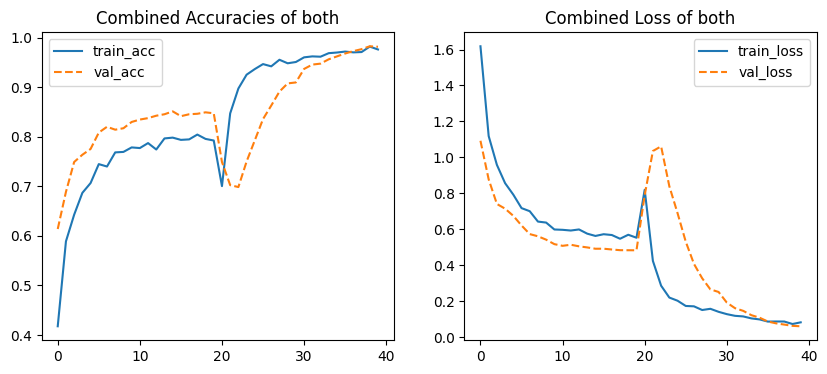

In [ ]:
plot_history(h_initial=model_base_frozen_initial_fitting.history, h_finetune=model_base_frozen_finetune_fitting.history)

In [ ]:
# list saved files
if os.path.exists(ckpt_path):
    print("Saved best model:", ckpt_path)
else:
    print("No checkpoint saved at", ckpt_path)

Saved best model: /content/MobileNetV2_best/best model.keras




---



# 11. Evaluation

In [ ]:
def dataset_to_labels_and_preds(model, ds):
    y_true = []
    y_pred = []
    for imgs, labs in ds:
        preds = model.predict(imgs, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1).tolist())
        y_true.extend(labs.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

In [ ]:
# load best model from checkpoint if exists
if os.path.exists(ckpt_path):
    try:
        best_model = keras.models.load_model(ckpt_path)
        print("Loaded best model from", ckpt_path)
    except Exception as e:
        print("Failed to load model from checkpoint:", e)
        best_model = model_base_frozen
else:
    best_model = model_base_frozen

Loaded best model from /content/MobileNetV2_best/best model.keras


In [ ]:
y_true, y_pred = dataset_to_labels_and_preds(best_model, test_ds)

print("Test set size:", len(y_true))

Test set size: 1028


In [ ]:
try:
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
except Exception as e:
    print("Could not print classification report:", e)

Classification Report:
              precision    recall  f1-score   support

         CaS       0.93      0.99      0.96       160
         CoS       0.99      0.99      0.99       149
         Gum       0.99      0.95      0.97       120
          MC       0.99      0.96      0.97       180
          OC       0.98      0.99      0.99       108
         OLP       0.98      0.94      0.96       180
          OT       0.95      0.98      0.97       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[159   1   0   0   0   0   0]
 [  1 148   0   0   0   0   0]
 [  5   0 114   0   0   0   1]
 [  1   0   1 172   2   3   1]
 [  0   0   0   1 107   0   0]
 [  5   0   0   0   0 170   5]
 [  0   0   0   1   0   1 129]]


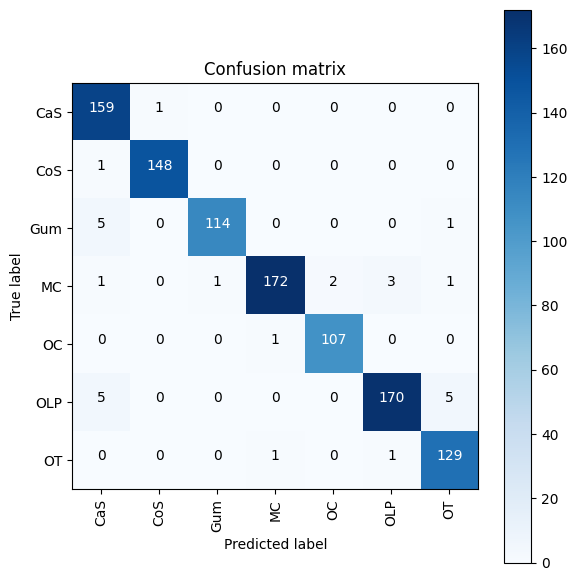

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cm, class_names, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, figsize=(6,6))


---



# 12. Streamlit app for deployment

This app:
* Loads your trained MobileNetV2 model (`best.keras` checkpoint).
* Lets the user upload a tooth image.
* Preprocesses it the same way as in training (resize → preprocess_input).
* Displays predicted class + confidence.

In [ ]:
# 1) install dependencies
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.0 MB/s eta 0:00:00


In [ ]:
## for using the token without showing it, delete after running it
# import os
# os.environ["NGROK_AUTH_TOKEN"] = "your-token-here"

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])

In [ ]:
# 2) python cell to start streamlit and expose via ngrok
from pyngrok import ngrok, conf
import time
import os
from IPython.display import display, HTML

In [ ]:
# %%
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow import keras
from keras.applications import mobilenet_v2
import numpy as np
from PIL import Image

# ====== CONFIG ======
MODEL_PATH = "/content/MobileNetV2_best/best model.keras"   # path to your saved best model
IMAGE_SIZE = (224, 224)                   # must match training
# IMAGE_SIZE = (64, 64)
CLASS_NAMES = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

# ====== LOAD MODEL ======
@st.cache_resource
def load_model():
    model = keras.models.load_model(MODEL_PATH)
    return model

model = load_model()
st.title("🦷 Teeth Classification App (MobileNetV2)")

# ====== UPLOAD IMAGE ======
uploaded_file = st.file_uploader("Upload a tooth image", type=["jpg","jpeg","png"])
if uploaded_file is not None:
    # Display image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded image", use_container_width=True)

    # Preprocess
    img_resized = image.resize(IMAGE_SIZE)
    x = np.array(img_resized).astype("float32")
    x = np.expand_dims(x, axis=0)  # shape (1,224,224,3)
    x = mobilenet_v2.preprocess_input(x)

    # Predict
    preds = model.predict(x)
    pred_class_idx = int(np.argmax(preds[0]))
    confidence = float(np.max(preds[0]))

    st.markdown(f"### Prediction: **{CLASS_NAMES[pred_class_idx]}**")
    st.markdown(f"Confidence: **{confidence:.2%}**")

    # Optional: show top-3 predictions
    st.subheader("Top-3 predictions:")
    top3_idx = preds[0].argsort()[-3:][::-1]
    for idx in top3_idx:
        st.write(f"{CLASS_NAMES[idx]}: {preds[0][idx]*100:.2f}%")

Writing app.py


In [ ]:
# path to your streamlit app
APP_PATH = "app.py"
PORT = 8501

In [ ]:
# Start Streamlit in the background (headless)
# --server.headless true avoids trying to open a browser on the host
streamlit_cmd = f"streamlit run {APP_PATH} --server.port {PORT} --server.headless true &"
print("Starting Streamlit with:", streamlit_cmd)
os.system(streamlit_cmd)

# Give Streamlit a few seconds to boot
time.sleep(3)

# Create an ngrok tunnel (http -> port 8501)
public_tunnel = ngrok.connect(PORT, bind_tls=True)
print("ngrok tunnel created:", public_tunnel.public_url)

# Optional: display clickable link in notebook
display_html = f'<a href="{public_tunnel.public_url}" target="_blank">Open Streamlit app (ngrok)</a>'
display_html += "<p>To stop the tunnel: run <code>ngrok.kill()</code> or restart Colab runtime.</p>"
display(HTML(display_html))

Starting Streamlit with: streamlit run app.py --server.port 8501 --server.headless true &
ngrok tunnel created: https://8e876aba8194.ngrok-free.app


### To close the site

In [ ]:
from pyngrok import ngrok

# Kill all ngrok tunnels
ngrok.kill()



---





---



# Notes:

## grad cam (search about it)

##